In [15]:
import os
import numpy as np
import cv2
from imutils import paths
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
from covid_detector.evaluate_covid19 import Evaluator

/Users/ninawiedemann/miniconda3/envs/covid_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ninawiedemann/miniconda3/envs/covid_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ninawiedemann/miniconda3/envs/covid_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/nin

### Functions for prediction of video label

In [3]:
def majority_vote(preds, gt, vid_filenames):
    """
    Arguments:
    	preds: predicted classes (1-d list of class_names or integers)
        gt: list of same size with ground truth labels
        vid_filenames: list of filenames
    """
    preds = np.asarray(preds)
    gt = np.asarray(gt)
    vids = np.asarray([vid.split(".")[0] for vid in vid_filenames])
    vid_preds_out = []
    for v in np.unique(vids):
        preds_video = preds[vids==v]
        gt_check = np.unique(gt[vids==v])
        assert len(gt_check)==1, "gt must have the same label for the whole video"
        labs, pred_counts = np.unique(preds_video, return_counts=True)
        # take label that is predicted most often
        vid_pred = labs[np.argmax(pred_counts)]
        print("preds for video:", preds_video)
        # print(v, vid_pred, gt_check[0])
        vid_preds_out.append([v, vid_pred, gt_check[0]])
    print("video accuracy (majority):", accuracy_score([p[1] for p in vid_preds_out], [p[2] for p in vid_preds_out]))
    return vid_preds_out
        
def average_certainty(preds_logits, gt, vid_filenames):
    """
    Arguments:
    	preds: predicted classes (1-d list of class_names or integers)
        gt: list of same size with ground truth labels
        vid_filenames: list of filenames
    """
    preds_logits = np.asarray(preds_logits)
    gt = np.asarray(gt)
    vid_preds_out = []
    vids = np.array([vid.split(".")[0] for vid in vid_filenames])
    for v in np.unique(vids):
        preds_video_logits = preds_logits[vids==v]
        preds_video = np.sum(preds_video_logits, axis=0)
        print("preds for video:", preds_video)
        gt_check = np.unique(gt[vids==v])
        assert len(gt_check)==1, "gt must have the same label for the whole video"
        # take label that is predicted most often
        vid_pred = np.argmax(preds_video)
        print(v, vid_pred, gt_check[0])
        vid_preds_out.append([v, vid_pred, gt_check[0]])
    print("video accuracy (certainty):", accuracy_score([p[1] for p in vid_preds_out], [p[2] for p in vid_preds_out]))
    return vid_preds_out

## Evaluation script for cross validation

In [4]:
saved_logits, saved_gt, saved_files = [], [], []

for i in range(5):
    print("------------- SPLIT ", i, "-------------------")
    # define data input path
    path = "../data_pocus/cross_validation_data/split"+str(i)
    
    train_labels, test_labels, test_files = [], [], []
    train_data, test_data = [], []

    # loop over the image paths (train and test)
    for imagePath in paths.list_images(path):

        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]

        # load the image, swap color channels, and resize it to be a fixed
        # 224x224 pixels while ignoring aspect ratio
        image = cv2.imread(imagePath)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.resize(image, (224, 224))

        # update the data and labels lists, respectively
        test_labels.append(label)
        test_data.append(image)
        test_files.append(imagePath.split(os.path.sep)[-1])

    # build ground truth data
    classes = ["covid", "pneunomia", "regular"]
    gt_class_idx = np.array([classes.index(lab) for lab in test_labels])
    
    model = Evaluator(split=str(i))
    
    logits = np.array([model(img) for img in test_data])
    
    # remember for evaluation:
    saved_logits.append(logits)
    saved_gt.append(gt_class_idx)
    saved_files.append(test_files)
    
    # output the information
    predIdxs = np.argmax(logits, axis=1)
    
    print(
    classification_report(
        gt_class_idx, predIdxs, target_names=classes
        )
    )

    vid_preds_certainty = average_certainty(logits, gt_class_idx, np.array(test_files))
    vid_preds_majority = majority_vote(predIdxs, gt_class_idx, np.array(test_files))

------------- SPLIT  0 -------------------
init
Loading weights from  ../trained_models/fold_0/variables/variables
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model restored. Class mappings are ['covid', 'pneunomia', 'regular']
              precision    recall  f1-score   support

       covid       0.70      0.56      0.62        63
   pneunomia       0.71      0.79      0.75        28
     regular       0.67      0.81      0.74        48

    accuracy                           0.69       139
   macro avg       0.69      0.72      0.70       139
weighted avg       0.69      0.69      0.69       139

preds for video: [0.41692764 5.862566   2.720506  ]
Cov-Atlas+(44) 1 0
preds for video: [0.2946806 1.1493942 3.5559251]
Cov-Atlas+(45) 2 0
preds for video: [0.2536777 2.318747  5.4275756]
Cov-Atlas-+(43) 2 0
preds for video: [1.0876949  0.30086467 

### Save outputs

In [6]:
import pickle
with open("eval.dat", "wb") as outfile:
    pickle.dump((saved_logits, saved_gt, saved_files), outfile)

## Evaluation plots

In [18]:
import seaborn as sn
import pandas as pd

In [ ]:
# confusion matrix with avg acc and std
# sensitivity, specificity, avg and std
# cm = confusion_matrix(testY.argmax(axis=1), predIdxs)

In [107]:
all_cms = np.zeros((5,3,3))
for s in range(5):
    # print(saved_files[s])
    gt_s = saved_gt[s]
    pred_idx_s = np.argmax(np.array(saved_logits[s]), axis=1)
    assert len(gt_s)==len(pred_idx_s)
    cm = np.array(confusion_matrix(gt_s, pred_idx_s))
    all_cms[s] = cm

In [99]:
data_sens = all_cms.copy()
for i in range(5):
    data_sens[i] = data_sens[i]/np.sum(data_sens[i], axis=1)
sens_stds = np.std(data_sens, axis = 0)
data_sens = np.mean(data_sens, axis=0)

In [97]:
data_sens

array([[0.82067295, 0.08782824, 0.32731481],
       [0.02904762, 0.93133641, 0.        ],
       [0.08288961, 0.        , 0.80175926]])

#### Function to make labels with std from the data

In [101]:
def data_to_label(data, text):
    return (np.asarray(["{0:.2f}\n".format(data)+u"\u00B1"+"{0:.2f}".format(text) for data, text in zip(data.flatten(), text.flatten())])).reshape(3,3)

array([['0.82\n±0.19', '0.09\n±0.12', '0.33\n±0.40'],
       ['0.03\n±0.04', '0.93\n±0.09', '0.00\n±0.00'],
       ['0.08\n±0.09', '0.00\n±0.00', '0.80\n±0.26']], dtype='<U10')

## Confusion matrix plots

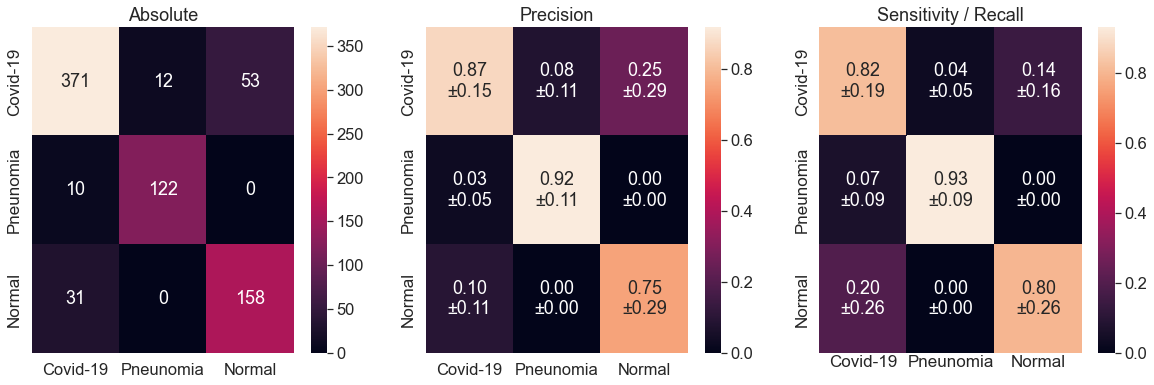

In [127]:
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)

data_abs = np.sum(all_cms, axis=0)
df_cm = pd.DataFrame(data_abs, index = [i for i in ["Covid-19", "Pneunomia", "Normal"]],
                  columns = [i for i in ["Covid-19", "Pneunomia", "Normal"]])

sn.set(font_scale=1.5)
plt.title("Absolute")
plt.yticks(np.arange(3)+0.5,("Covid-19", "Pneunomia", "Normal"), rotation=0, fontsize="17", va="center")
sn.heatmap(df_cm, annot=True, fmt="g")


# PRECISION SUBPLOT
plt.subplot(1,3,2)

data_prec = all_cms.copy()
for i in range(5):
    data_prec[i] = data_prec[i]/np.sum(data_prec[i], axis=0)
prec_stds = np.std(data_prec, axis = 0)
data_prec = np.mean(data_prec, axis=0)
labels_prec = data_to_label(data_prec, prec_stds)

df_cm = pd.DataFrame(data_prec, index = [i for i in ["Covid-19", "Pneunomia", "Normal"]],
                  columns = [i for i in ["Covid-19", "Pneunomia", "Normal"]])
sn.set(font_scale=1.5)
plt.ylabel("ground truth")
plt.xlabel("predictions")
plt.title("Precision")
plt.yticks(np.arange(3)+0.5,("Covid-19", "Pneunomia", "Normal"), rotation=0, fontsize="17", va="center")
sn.heatmap(df_cm, annot=labels_prec, fmt='')


#  SENSITIVITY SUBPLOT
plt.subplot(1,3,3)
data_sens = all_cms.copy()
for i in range(5):
    sums_axis = np.sum(data_sens[i], axis=1)
    data_sens[i] = np.array([data_sens[i,j,:]/sums_axis[j] for j in range(3)])
sens_stds = np.std(data_sens, axis = 0)
data_sens = np.mean(data_sens, axis=0)

labels_sens = data_to_label(data_sens, sens_stds)
df_cm = pd.DataFrame(data_sens, index = [i for i in ["Covid-19", "Pneunomia", "Normal"]],
                  columns = [i for i in ["Covid-19", "Pneunomia", "Normal"]])
sn.set(font_scale=1.5)
plt.title("Sensitivity / Recall")
plt.yticks(np.arange(3)+0.5,("LALAL-19", "Pneunomia", "Normal"), rotation=0, fontsize="17", va="center")
plt.xticks(np.arange(3)+0.5,("LALAL-19", "Pneunomia", "Normal"), rotation=0, fontsize="17", va="center")


sn.heatmap(df_cm, annot=labels_sens, fmt='')
# plt.savefig("confusion_matrix.png")


# Tests

In [30]:
model = Evaluator(split=str(i))

init
../trained_models/fold_0/pocus_fold_0.model
Model restored. Class mappings are ['covid', 'pneunomia', 'regular']


In [31]:
logits = np.array([model(img) for img in test_data])
predIdxs = np.argmax(logits, axis=1)

print(
classification_report(
    gt_class_idx, predIdxs, target_names=classes
    )
)

vid_preds_certainty = average_certainty(logits, gt_class_idx, np.array(test_files))
vid_preds_majority = majority_vote(predIdxs, gt_class_idx, np.array(test_files))

              precision    recall  f1-score   support

       covid       0.56      0.56      0.56        63
   pneunomia       0.44      0.79      0.56        28
     regular       0.67      0.38      0.48        48

    accuracy                           0.54       139
   macro avg       0.56      0.57      0.53       139
weighted avg       0.57      0.54      0.53       139

Cov-Atlas+(44) 1 0
Cov-Atlas+(45) 1 0
Cov-Atlas-+(43) 1 0
Cov-Atlas-Day+1 2 0
Cov-Atlas-Day+2 0 0
Cov-Atlas-Day+3 0 0
Cov-Atlas-Day+4 0 0
Cov-B_ConvexProb_score1 0 0
Pneu-grep-pneumonia2 1 1
Reg-Atlas 0 2
Reg-Atlas-alines 2 2
Reg-Atlas-lungcurtain 1 2
Reg-Youtube 0 2
video accuracy (certainty): 0.46153846153846156
video accuracy (majority): 0.46153846153846156


In [49]:
model2 = Evaluator(split=str(i))

init
../trained_models/fold_0/variables/variables
Model restored. Class mappings are ['covid', 'pneunomia', 'regular']
